<a href="https://colab.research.google.com/github/m-abbas-ansari/SuperResolution-DEMs/blob/main/Upsampling-DEMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q rasterio

from google.colab import drive

drive.mount('./gdrive')

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
Mounted at ./gdrive


In [ ]:
!cp -r gdrive/Shareddrives/TeamDriveForJmi/SIH/Kernels .
print(f"Successfully copied {len(os.listdir('Kernels/results'))} Kernels")

In [ ]:
import os
import shutil 
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat
from scipy.ndimage import correlate
from torch.autograd import Variable
from math import exp, log2, ceil, pow

### Metrics and Utilities

In [ ]:
def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

def unnormalize_dem(im):
  MIN_H = -500.0
  MAX_H = 10000.0
  return (im*(MAX_H - MIN_H)) - 500

In [ ]:
'''SSIM Loss function taken from: https://github.com/Po-Hsun-Su/pytorch-ssim'''

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)*2/float(2*sigma*2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2
    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2
    C1 = 0.01**2
    C2 = 0.03**2
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            self.window = window
            self.channel = channel
        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
import math

def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(10500.0 / math.sqrt(mse))

### Upsampling function

In [ ]:
@torch.no_grad()
def upsample_2x(dem, upsampler, window_size):
  '''
  Args: 
    dem (tensor) : DEM to be upsampled
    upsampler (nn.Module) : function to use for upsampling (should upsample by 2)
    window_size (int) : size of the patch window acceptable by upsampler
  '''
  sf = 2
  height, width = dem.size()
  sr_dem = torch.zeros((height*2, width*2)).cuda()
  ylist = list(range(0, height-window_size, 128))
  if height-window_size not in ylist:
    ylist += [height-window_size]

  xlist = list(range(0, width-window_size, 128))
  if width-window_size not in xlist:
    xlist += [width-window_size]

  for y in ylist:
    for x in xlist:
      patch = dem[y: y + window_size, x: x + window_size]
      upsampled_patch = upsampler(patch.unsqueeze(0).unsqueeze(0))
      sr_dem[y*sf: (y+window_size)*sf, x*sf: (x+window_size)*sf] = upsampled_patch.squeeze()
  print(f'DEM of size {tuple(dem.size())} upsampled to {tuple(sr_dem.size())}')
  return sr_dem

@torch.no_grad()
def upsample_any_sf(dem, upsampler, window_size, scale_factor):
  power2 = ceil(log2(scale_factor))
  for _ in range(power2):
    dem = upsample_2x(dem, upsampler, window_size)
  
  final_sf = round(float(scale_factor) / pow(2, power2), 5)
  sr_dem = F.interpolate(dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), scale_factor=final_sf, mode='bilinear')

  return sr_dem.squeeze()

In [ ]:
!git clone https://github.com/m-abbas-ansari/SuperResolution-DEMs.git
%cd SuperResolution-DEMs
from usrnet_att import USRNet
%cd ..

Cloning into 'SuperResolution-DEMs'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 15), reused 34 (delta 7), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/SuperResolution-DEMs
/content


In [ ]:
network = USRNet(2, 32, 256, 32)
network = network.to('cuda')

In [ ]:
network.load_state_dict(torch.load("gdrive/Shareddrives/TeamDriveForJmi/SIH/saved_models/usrnet/usrnet_att_large_data_1.pkl"), strict=False)

<All keys matched successfully>

### Utils


In [ ]:
!pip install exifread

import exifread
# Open image file for reading (binary mode)
f = open(dem_paths[1], 'rb')

# Return Exif tags
tags = exifread.process_file(f)

# Print the tag/ value pairs
for tag in tags.keys():
    if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
        print(f"Key: {tag}, value {tags[tag]}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Key: Image ImageWidth, value 1872
Key: Image ImageLength, value 1510
Key: Image BitsPerSample, value [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Key: Image Compression, value Uncompressed
Key: Image PhotometricInterpretation, value 1
Key: Image StripOffsets, value [8, 82376, 164744, 247112, 329480, 411848, 494216, 576584, 658952, 741320, 823688, 906056, 988424, 1070792, 1153160, 1235528, 1317896, 1400264, 1482632, 1565000, ... ]
Key: Image Orientation, value Horizontal (normal)
Key: Image SamplesPerPixel, value 11
Key: Image RowsPerStrip, value 2
Key: Image StripByteCounts, value [82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, 82368, ... ]
Key: Image XResolution, value 1
Key: Image YResolution, value 1
Key: Image PlanarConfiguration, value 1
Key: Image ResolutionUnit, value Not Absolute
Key: Image Softw

### DEM

In [ ]:
import rasterio as rio
dem_paths = glob.glob('gdrive/Shareddrives/TeamDriveForJmi/SIH/Test_DEMs/*.tif')
dem30 = rio.open(dem_paths[-2]).read(1).astype('float')
dem90 = rio.open(dem_paths[-1]).read(1).astype('float')

In [ ]:
dem30 = dem30[:3600, :3600]

In [ ]:
import torch.nn.functional as F
lr = F.interpolate(torch.tensor(normalize(dem30)).unsqueeze(0).unsqueeze(0), size=1200, mode='bilinear')

In [ ]:
lr.size()

torch.Size([1, 1, 1200, 1200])

In [ ]:
dem30_tensor = torch.tensor(dem30)

In [ ]:
hr = upsample_any_sf(lr.squeeze().type(torch.FloatTensor).cuda(), network, 128, 3)

DEM of size (1200, 1200) upsampled to (2400, 2400)
DEM of size (2400, 2400) upsampled to (4800, 4800)


In [ ]:
hr_bic = F.interpolate(lr, scale_factor=3, mode='bicubic')

In [ ]:
hr.size()

torch.Size([3600, 3600])

In [ ]:
plt.imsave('DEM_90m_down.jpg', lr.cpu().numpy(), cmap='Greys_r')
plt.imsave('SRDEM_30m.jpg', hr.cpu().numpy(), cmap='Greys_r')
plt.imsave('Bicbubic_30m.jpg', hr_bic.cpu().numpy(), cmap='Greys_r')
plt.imsave('DEM_30m.jpg', dem30, cmap='Greys_r')

In [ ]:
!pip install -q elevation richdem

     |████████████████████████████████| 4.5 MB 4.0 MB/s 


In [ ]:
elevation.clip(bounds=(-122.4, 41.2, -122.1, 41.5), output=dem_paths[-2])

CalledProcessError: ignored

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd

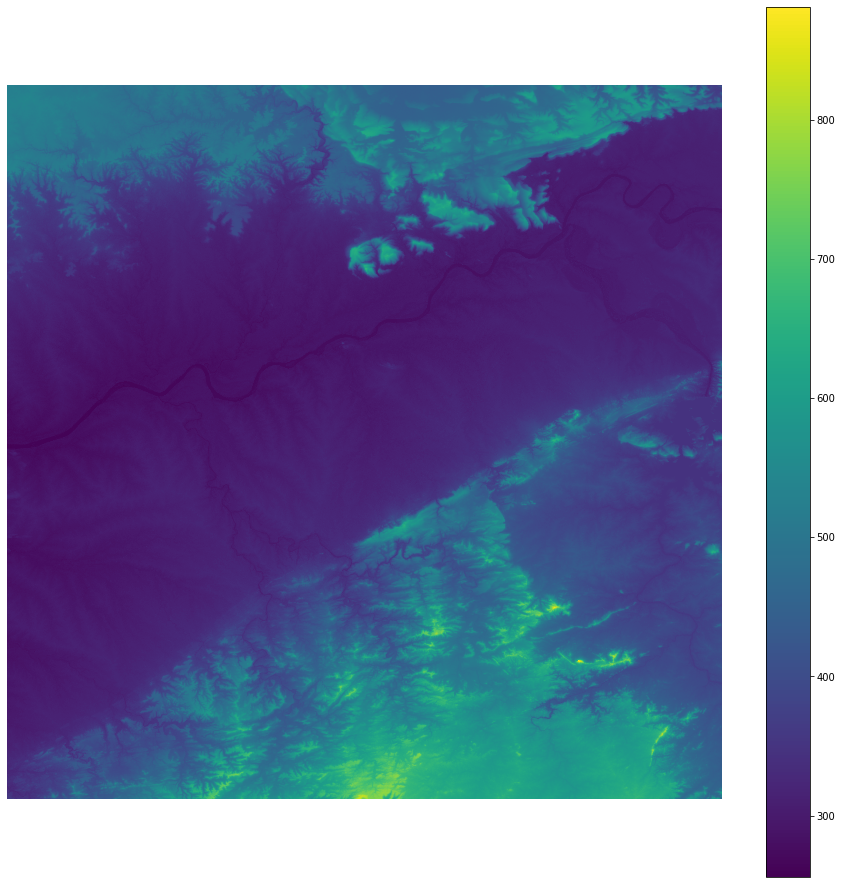

In [ ]:
plt.imshow(dem30, interpolation='none')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from scipy.ndimage import label, binary_dilation
from collections import Counter

def impute(arr):
    imputed_array = np.copy(arr)

    mask = (dem90 == -32767.0)
    labels, count = label(mask)
    for idx in range(1, count + 1):
        hole = labels == idx
        surrounding_values = arr[binary_dilation(hole) & ~hole]
        most_frequent = Counter(surrounding_values).most_common(1)[0][0]
        imputed_array[hole] = most_frequent

    return imputed_array

In [ ]:
dem90 = impute(dem90)

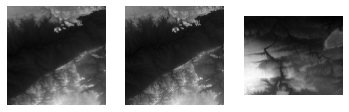

In [ ]:
dem10 = normalize(rio.open(dem_paths[1]).read(1).astype('float'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (16, 16)
ax1.axis('off')
ax1.imshow(dem90, cmap='Greys_r')
ax2.axis('off')
ax2.imshow(dem30, cmap='Greys_r')
ax3.axis('off')
ax3.imshow(dem10, cmap='Greys_r')


In [ ]:
dem30.min(), dem30.max(), dem90.min(), dem90.max()

(256.0, 881.0, 258.0, 879.0)

In [ ]:
imputed_dem = impute(dem90)

In [ ]:
imputed_dem.min(), imputed_dem.max()

(258.0, 879.0)

In [ ]:
dem90 = imputed_dem

In [ ]:
for i in range(1201):
  for j in range(1201):
    if dem90[i][j] < 0:
      dem90[i][j] = 0

In [ ]:
dem90 = normalize(dem90)
dem30 = normalize(dem30)

In [ ]:
dem30_tensor = torch.tensor(dem30[:3600, :3600])

In [ ]:
dem_tensor = torch.tensor(dem90[:1200, :1200])
sr_dem =  upsample_any_sf(dem_tensor.type(torch.FloatTensor).cuda(), network, 128, 3)

DEM of size (1200, 1200) upsampled to (2400, 2400)
DEM of size (2400, 2400) upsampled to (4800, 4800)


In [ ]:
dem_tensor.size(), sr_dem.size()

(torch.Size([1200, 1200]), torch.Size([3600, 3600]))

In [ ]:
sr_10dem = upsample_3x(dem30_tensor.type(torch.FloatTensor).cuda(), network, 128)

DEM of size (3600, 3600) upsampled to (10800, 10800)


In [ ]:
sr_10dem.size()

torch.Size([10800, 10800])

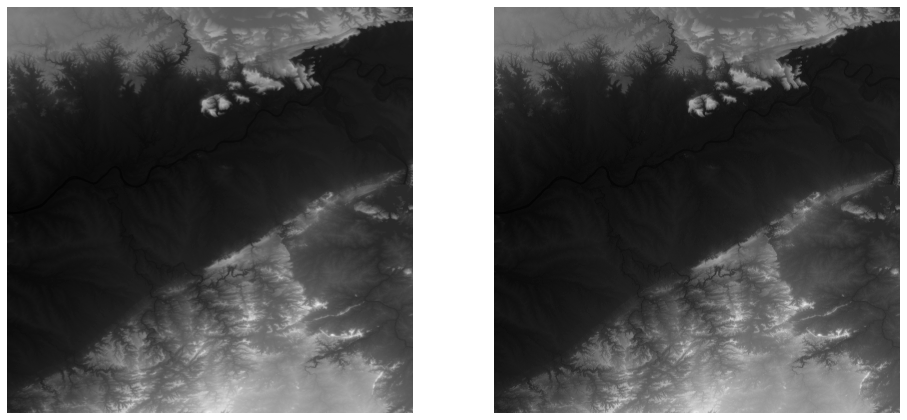

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (16, 16)
ax1.axis('off')
ax1.imshow(sr_dem.cpu().numpy(), cmap='Greys_r')
ax2.axis('off')
ax2.imshow(sr_10dem.cpu().numpy(), cmap='Greys_r')

In [ ]:
hrdem = normalize(dem30[:3600, :3600])
hrdem_tensor = torch.tensor(hrdem)

In [ ]:
plt.imsave('DEM_90m.jpg', dem_tensor.cpu().numpy(), cmap='Greys_r')
plt.imsave('SRDEM_30m.jpg', sr_dem.cpu().numpy(), cmap='Greys_r')
plt.imsave('SRDEM_10m.jpg', sr_10dem.cpu().numpy(), cmap='Greys_r')
plt.imsave('DEM_30m.jpg', hrdem_tensor.cpu().numpy(), cmap='Greys_r')

In [ ]:
def unnormalize_dem(im):
  return (im*10500) - 500

In [ ]:
!pip install tifffile
from tifffile import imsave

imsave('sr30m.tif', sr_dem.cpu().numpy())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imageio

imageio.imwrite('dem90m.tif', unnormalize_dem(dem_tensor.cpu().numpy()))

In [ ]:
!cp dem90m.tif gdrive/Shareddrives/TeamDriveForJmi/SIH/dem90m.tif

In [ ]:
data = rio.open('gdrive/Shareddrives/TeamDriveForJmi/SIH/sr10mio.tif').read(1).astype('float')

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
data = normalize(data)
plt.imsave('sr10m.jpg', data, cmap='Greys_r')

In [ ]:
data.min(), data.max()

(251.73773193359375, 949.0972900390625)

In [ ]:
calculate_psnr(data, dem30[:3600, :3600])

-12.053003890723822

In [ ]:
ssim = SSIM().to('cuda')
mae = nn.L1Loss().to('cuda')
mse = nn.MSELoss().to('cuda')

In [ ]:
mae_value = mae(hr.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), dem30_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())
mse_value = mse(hr.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), dem30_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())
ssim_value = ssim(hr.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), dem30_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())
psnr_value = calculate_psnr(hr.cpu().numpy(), hrdem)

In [ ]:
print("MAE: ", mae_value.item())
print("MSE: ", mse_value.item())
print("SSIM: ", ssim_value.item())
print("PSNR: ", psnr_value)

MAE:  442.1628112792969
MSE:  237369.046875
SSIM:  0.24603259563446045
PSNR:  21.472619385513475


In [ ]:
# plt.rcParams["figure.figsize"] = (8, 8)
# plt.axis('off')
# difference_dem = abs(hrdem_tensor.cpu() - sr_dem.cpu())
# plt.imshow(difference_dem.numpy(), cmap='Greys_r')

In [ ]:
ssim(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), bil_up.type(torch.FloatTensor).cuda())

tensor(1.0000, device='cuda:0')

In [ ]:
dem_tensor.size()

torch.Size([300, 300])

In [ ]:
def numeric_kernel(im, kernel, scale_factor, output_shape):
    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    # print(f'{type(im)} {type(kernel)}')
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

In [ ]:
kernel_dir = "Kernels/results"
kernel_list = glob.glob(kernel_dir + '/*.mat')

In [ ]:
kernel = loadmat(kernel_list[0])["Kernel"]

In [ ]:
hrdem

array([[0.09742857, 0.09752381, 0.09752381, ..., 0.08314286, 0.08314286,
        0.08333333],
       [0.09733333, 0.09752381, 0.09752381, ..., 0.08333333, 0.08333333,
        0.08352381],
       [0.09742857, 0.09752381, 0.09761905, ..., 0.08361905, 0.08361905,
        0.08390476],
       ...,
       [0.08085714, 0.08114286, 0.0812381 , ..., 0.09238095, 0.09247619,
        0.09257143],
       [0.08057143, 0.08085714, 0.08114286, ..., 0.09238095, 0.09257143,
        0.09295238],
       [0.08019048, 0.08057143, 0.08095238, ..., 0.09266667, 0.09285714,
        0.09333333]])

In [ ]:
hrdem.shape

(3600, 3600)

In [ ]:
hrdem_tensor = torch.tensor(hrdem)

In [ ]:
lrdem = numeric_kernel(hrdem, kernel, [0.2,0.2], (300, 300)).astype(np.float32)

In [ ]:
lrdem_tensor = torch.tensor(lrdem)

In [ ]:
srdem = upsample_any_sf(lrdem_tensor.type(torch.FloatTensor).cuda(), network, 128, 5)

DEM of size (300, 300) upsampled to (600, 600)
DEM of size (600, 600) upsampled to (1200, 1200)
DEM of size (1200, 1200) upsampled to (2400, 2400)


In [ ]:
nn.L1Loss()(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(0.0002, device='cuda:0')

In [ ]:
nn.MSELoss()(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(1.5894e-07, device='cuda:0')

In [ ]:
ssim(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(0.9999, device='cuda:0')

In [ ]:
calculate_psnr(sr_dem.cpu().numpy(), hrdem)

67.98754862501836

In [ ]:
lrdem_tensor = dem_tensor[:1200, :1200]
bil_up = F.interpolate(lrdem_tensor.unsqueeze(0).unsqueeze(0), scale_factor=3, mode = 'bilinear')
ssim(bil_up.type(torch.FloatTensor).cuda(), sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(1.0000, device='cuda:0')

In [ ]:
nn.L1Loss()(bil_up.type(torch.FloatTensor).cuda(), sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(0.0001, device='cuda:0')

In [ ]:
nn.MSELoss()(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())

tensor(1.5894e-07, device='cuda:0')

In [ ]:
mae_value = mae(unnormalize_dem(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()), unnormalize_dem(hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()))
mse_value = mse(unnormalize_dem(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()), unnormalize_dem(hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()))
ssim_value = ssim(sr_dem.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda(), hrdem_tensor.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda())
psnr_value = calculate_psnr(unnormalize_dem(sr_dem.cpu().numpy()), unnormalize_dem(hrdem))

In [ ]:
print("MAE: ", mae_value.item())
print("MSE: ", mse_value.item())
print("SSIM: ", ssim_value.item())
print("PSNR: ", psnr_value)

MAE:  394.0458984375
MSE:  165977.03125
SSIM:  0.8534770607948303
PSNR:  28.223305474385917
